<a href="https://colab.research.google.com/github/pds2021/capstone-group_2/blob/Projekt_PDS/3_RetinaNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# RetinaNet
In diesem Notebook geht es ausschließlich um die Erstellung des Retinanets.

# Imports

In [ ]:
!pip install -Uqq fastai
from fastai.vision.all import *
import numpy as np
import pandas as pd 
import os
from fastai import *
import json

# Aufbereitung der Daten

In [ ]:
path = Path('/kaggle/input/iwildcam-2020-fgvc7')

Als Erstes wird die Textdatei im COCO Style (generiert über das [1_Projekt_Lösungen](https://github.com/pds2021/capstone-group_2/blob/Projekt_PDS/1_Projekt_L%C3%B6sungen.ipynb) mit der get_annotations Funktion aufgerufen. In imgs werden alle Dateinamen in einer Liste gespeichert, in lbl_bbox das Label mit der jeweiligen Bounding Box.

In [ ]:
imgs, lbl_bbox = get_annotations('/kaggle/input/coco-for-get-annotations/coco.txt')

Anschließend werden diese als Dictionary zusammengefügt.

In [ ]:
img2bbox = dict(zip(imgs, lbl_bbox))

Es werden zunächst einige Funktionen für den Datablock definiert.

In [ ]:
def getPath(o):
    return path/'train'/o

def getBbox(o):
    return img2bbox[o][0]

def getLbl(o):
    return img2bbox[o][1]

Getters fasst den Dateipfad, Dateinamen und Bounding Box mit dem richtigen Label (über das oben erstellte Dictionary) zusammen. Mit item_tfms und batch_tfms wird angegeben, wie die Bilder transformiert werden sollen. Die get_train_imgs Funktion sorgt dafür, dass auch wirklich Bilder zurückgegeben werden.  

In [ ]:
getters = [getPath, getBbox, getLbl]
item_tfms = [Resize(192, method='pad'),]
batch_tfms = [Rotate(), Flip(), Dihedral(), Normalize.from_stats(*imagenet_stats)]

def get_train_imgs(noop): return imgs

# Erstellung des DataBlocks und DataLoaders
n_inp wird auf 1 gesetzt, da ein Input erwartet wird. Bei der Erstellung des Datablocks sollte darauf geachtet werden keine Lambda Funktionen zu verwenden, da sonst im Anschluss das Exportieren des Modells erschwert wird.

In [ ]:
dBlock = DataBlock(blocks=(ImageBlock, BBoxBlock, BBoxLblBlock),
                 splitter=RandomSplitter(),
                 get_items=get_train_imgs,
                 getters=getters,
                 item_tfms=item_tfms,
                 batch_tfms=batch_tfms,
                 n_inp=1)

Nun wird mit Hilfe des Datablocks der Dataloader erstellt. Die Batchgröße wurde hier auf 32 reduziert, da sonst bei der Ausführung die GPU nicht genutzt werden kann.

In [ ]:
dls = dBlock.dataloaders(path/'train', bs=32)

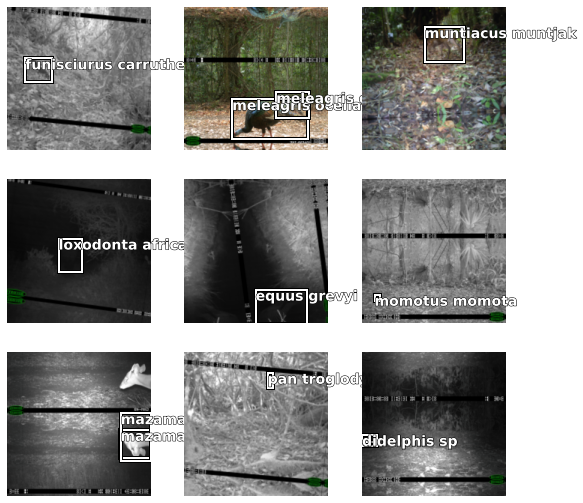

In [ ]:
dls.show_batch()

Die Anzahl der zu untersuchenden Klassen beträgt 267 (mit get_c aufrufbar). Diese Information wird später für die Architektur des RetinaNets benötigt.

In [ ]:
dls.c = 267

In [ ]:
get_c(dls)

267

# Repository Import
Im Folgenden wird das Repository von [Zachary Mueller](https://github.com/muellerzr) geclont und in einem separaten Ordner gespeichert.

In [ ]:
!git clone https://github.com/muellerzr/Practical-Deep-Learning-for-Coders-2.0.git
%cd "Practical-Deep-Learning-for-Coders-2.0/Computer Vision"

Cloning into 'Practical-Deep-Learning-for-Coders-2.0'...
remote: Enumerating objects: 65, done.
remote: Counting objects: 100% (65/65), done.
remote: Compressing objects: 100% (58/58), done.
remote: Total 1292 (delta 18), reused 27 (delta 6), pack-reused 1227
Receiving objects: 100% (1292/1292), 86.33 MiB | 21.43 MiB/s, done.
Resolving deltas: 100% (805/805), done.
/kaggle/working/Practical-Deep-Learning-for-Coders-2.0/Computer Vision


In [ ]:
from imports import *

Für die Architektur des RetinaNets wird ein Encoder benötigt. Zusätzlich setzen wir final_bias auf -4, weil das Netz zunächst den Hintergrund gut vorhersagen soll. Dadurch wird zuerst die letzte Convolution des Classifiers mit Gewichten = 0 und der Bias initialisiert, sodass immer -4 zurückgegeben wird. Die Sigmoid Funktion an der Stelle -4 beträgt 0,018.

In [ ]:
encoder = create_body(resnet34, pretrained=True)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

In [ ]:
arch = RetinaNet(encoder, get_c(dls), final_bias=-4)

Im nächsten Schritt werden die Seitenverhältnisse und Maßstäbe der Bilder angepasst.

In [ ]:
ratios = [1/2,1,2]
scales = [1,2**(-1/3), 2**(-2/3)]

In [ ]:
crit = RetinaNetFocalLoss(scales=scales, ratios=ratios)

In [ ]:
def _retinanet_split(m):
    return L(m.encoder,nn.Sequential(m.c5top6, m.p6top7, m.merges, m.smoothers, m.classifier, m.box_regressor)).map(params)

# Training
Jetzt kann der Learner erstellt werden. Als Erstes wird der Encoder gefreezed. Der Rest bleibt zunächst unfrozen.

In [ ]:
learn1 = Learner(dls, arch, loss_func=crit, splitter=_retinanet_split)

In [ ]:
learn1.freeze()

In [ ]:
learn1.lr_find()

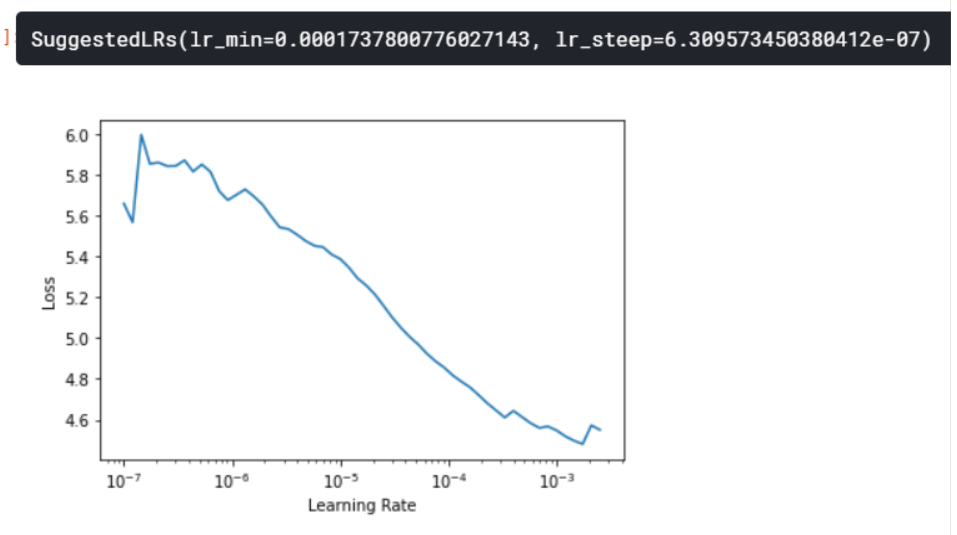

Nun wird für 5 Epochen mit der eben bestimmten Learning Rate trainiert.

In [ ]:
learn1.fit_one_cycle(5, 0.0002)

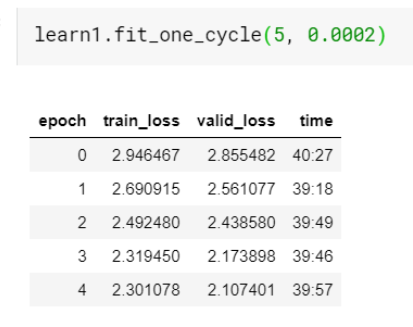

In [ ]:
learn1.save('stage1_learn1.h5')

In [ ]:
learn1.unfreeze()

In [ ]:
learn1.fit_one_cycle(5, slice(0.00014, 0.0002))

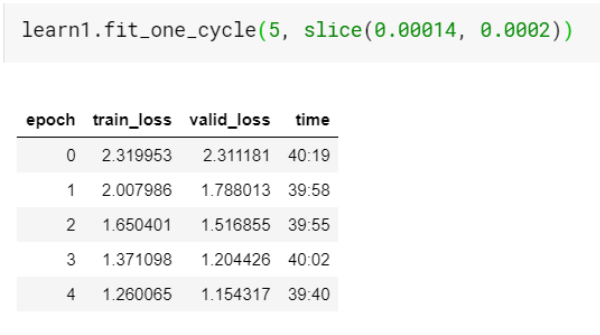

In [ ]:
learn1.save('stage2_learn1.h5')

In [ ]:
learn1.export('my_export_stage2.pkl')

# Auswertung
Das trainierte Modell wurde in einem [Dataset](https://www.kaggle.com/emanuelelias1/retinanet-pkl) gespeichert. 

In [ ]:
retModel = load_learner('/kaggle/input/retinanet-pkl/my_export_stage2.pkl')

Mit den folgenden Funktionen erhält man die bounding boxes, predictions und scores:

In [ ]:
def process_output(output, i, detect_thresh=0.25):
    clas_pred,bbox_pred,sizes = output[0][i], output[1][i], output[2]
    anchors = create_anchors(sizes, ratios, scales).to(clas_pred.device)
    bbox_pred = activ_to_bbox(bbox_pred, anchors)
    clas_pred = torch.sigmoid(clas_pred)
    detect_mask = clas_pred.max(1)[0] > detect_thresh
    bbox_pred, clas_pred = bbox_pred[detect_mask], clas_pred[detect_mask]
    bbox_pred = tlbr2cthw(torch.clamp(cthw2tlbr(bbox_pred), min=-1, max=1))    
    if clas_pred.numel() == 0: return [],[],[]
    scores, preds = clas_pred.max(1)
    return bbox_pred, scores, preds

def get_predictions(output, idx, detect_thresh=0.05):
    bbox_pred, scores, preds = process_output(output, idx, detect_thresh)
    if len(scores) == 0: return [],[],[]
    to_keep = nms(bbox_pred, scores)
    return bbox_pred[to_keep], preds[to_keep], scores[to_keep]

def get_bboxes(model, dl, n_classes, iou_thresh=0.5, detect_thresh=0.35, num_keep=100):
    tps, clas, p_scores = [], [], []
    classes, n_gts = LongTensor(range(n_classes)),torch.zeros(n_classes).long()
    bb_list = []
    bb_score_list = [] 
    pred_list = []
    with torch.no_grad():
        for inp,t1,t2 in progress_bar(dl):
            output = model(inp)
            for i in range(len(t1)):
                bbox_pred, preds, scores = get_predictions(output, i, detect_thresh)
                if len(scores) != 0:
                    # Copy to cpu
                    bbox_pred, preds, scores = bbox_pred.cpu(), preds.cpu(), scores.cpu()
                    # Get size factor
                    t_sz = torch.Tensor([*inp.shape[-2:]])[None].float()
                    # Convert predictions
                    bbox_pred[:,:2] = bbox_pred[:,:2] - bbox_pred[:,2:]/2
                    bbox_pred[:,:2] = (bbox_pred[:,:2] + 1) * t_sz/2
                    bbox_pred[:,2:] = bbox_pred[:,2:] * t_sz/2
                    # Save as int64
                    bbox_pred = bbox_pred.long()
                bb_list += [bbox_pred]
                bb_score_list += [scores]
                pred_list += [preds]
    return bb_list, bb_score_list, pred_list

Output für dls.valid:

In [ ]:
bb_list, bb_score_list, pred_list  = get_bboxes(retModel.model, dls.valid, dls.c-1, detect_thresh=0.35)

Die bounding boxes aus dem RetinaNet sind in einer anderen Reihenfolge als die im COCO Format. Hier werden diese entsprechend umsortiert.

In [ ]:
box = bb_list[0][:,[1, 0, 3, 2]]
box

In [ ]:
bb_score_list[0]

In [ ]:
lbl = pred_list[0]
lbl

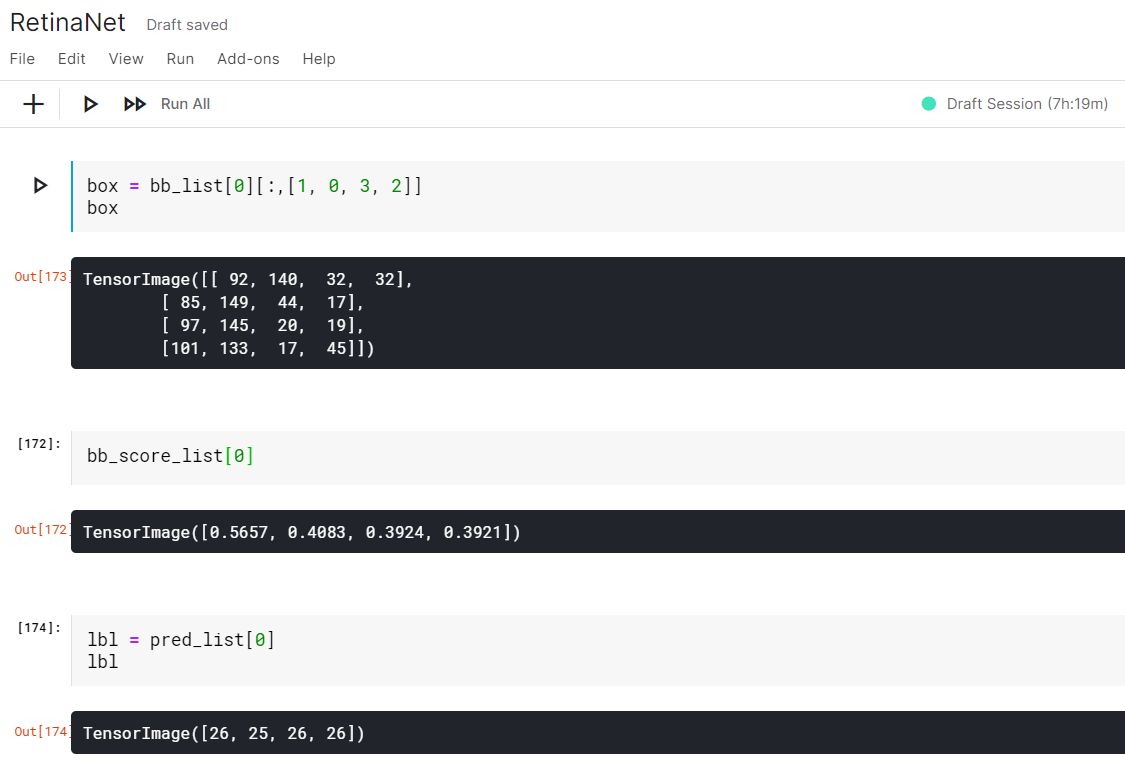

# Beispiel Output
Aufgrund des Datenumfangs und den mangelnden Ressourcen ist es uns nicht möglich gewesen, mit der beschränkten Ausführzeit das Modell auf alle Testbilder anzuwenden. In diesem Abschnitt wird das Modell beispielhaft an zwei Bildern aufgezeigt.

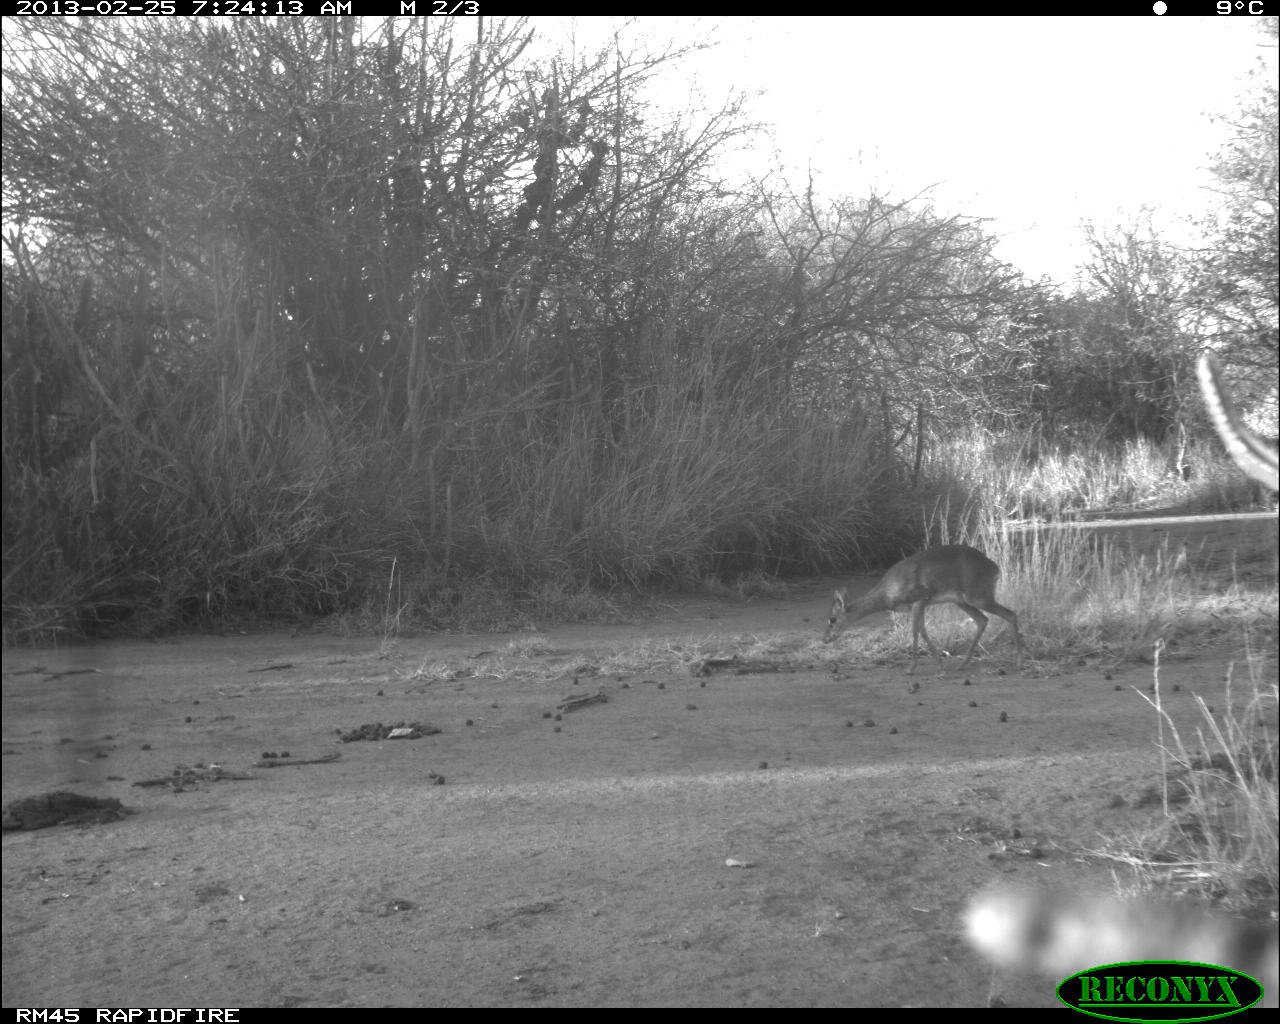

In [ ]:
img = PILImage.create('../input/iwildcam-2020-fgvc7/test/957f9414-21bc-11ea-a13a-137349068a90.jpg')
img

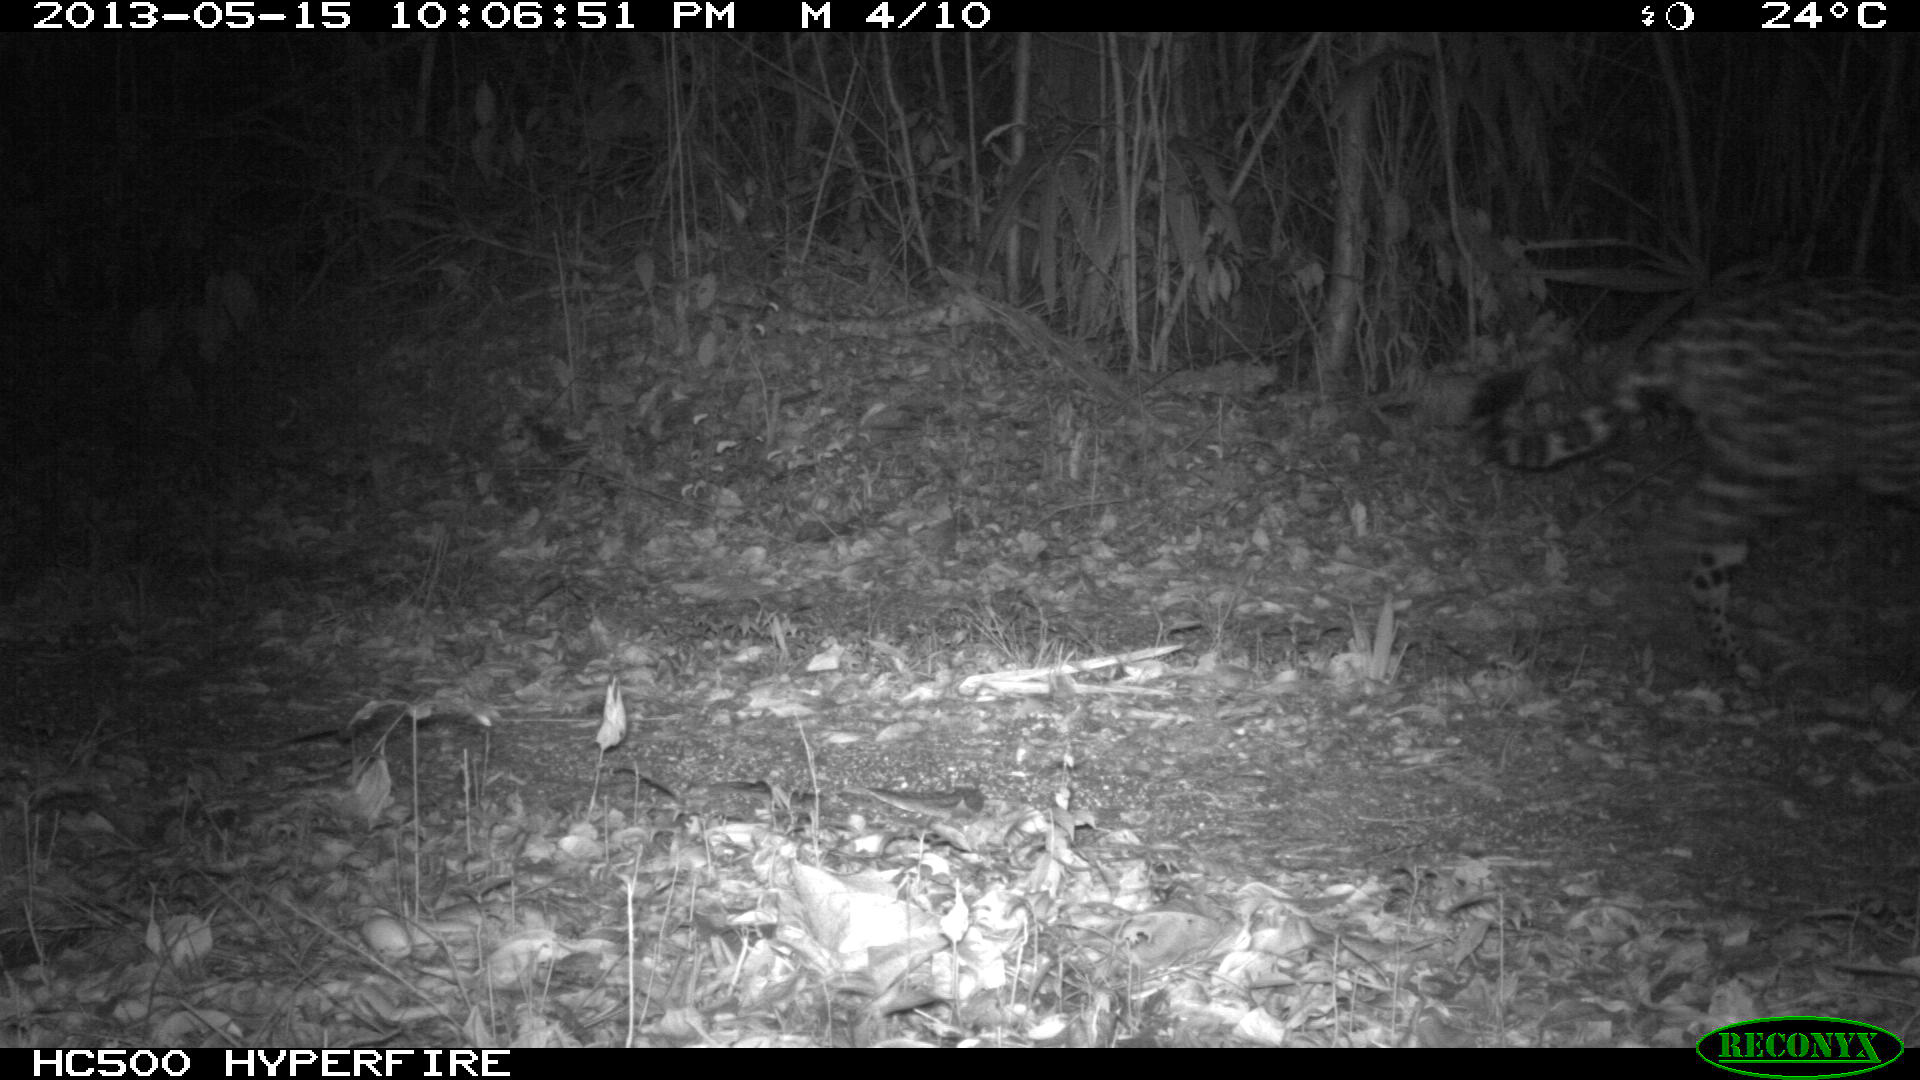

In [ ]:
img2 = PILImage.create('../input/iwildcam-2020-fgvc7/test/9310face-21bc-11ea-a13a-137349068a90.jpg')
img2

Es wird ein weiterer Ordner "images" erstellt, indem die Testbilder geladen werden.

In [ ]:
os.mkdir("images")
os.listdir()

['__notebook_source__.ipynb',
 'Practical-Deep-Learning-for-Coders-2.0',
 'images']

In [ ]:
!cp ../input/iwildcam-2020-fgvc7/test/957f9414-21bc-11ea-a13a-137349068a90.jpg /kaggle/working/images
!cp ../input/iwildcam-2020-fgvc7/test/9310face-21bc-11ea-a13a-137349068a90.jpg /kaggle/working/images

Die bounding boxes wurden mittels [2_MegaDetector_V4](https://github.com/pds2021/capstone-group_2/blob/Projekt_PDS/2_MegaDetector_V4.ipynb) ermittelt. Die nächsten Schritte verlaufen analog zum oberen Teil.

In [ ]:
liste3 = ['957f9414-21bc-11ea-a13a-137349068a90.jpg', '9310face-21bc-11ea-a13a-137349068a90.jpg']
liste4 = [([[0.6447,0.5311,0.1557,0.1182], [0.7415,0.8531,0.2584,0.1263], [0.9307,0.337,0.06897,0.1544]], [1,1,1]) ,([[0.7618,0.251,0.2362,0.3822]], [1])]

In [ ]:
img2bbox_v2 = dict(zip(liste3, liste4))
img2bbox_v2

{'957f9414-21bc-11ea-a13a-137349068a90.jpg': ([[0.6447,
    0.5311,
    0.1557,
    0.1182],
   [0.7415, 0.8531, 0.2584, 0.1263],
   [0.9307, 0.337, 0.06897, 0.1544]],
  [1, 1, 1]),
 '9310face-21bc-11ea-a13a-137349068a90.jpg': ([[0.7618,
    0.251,
    0.2362,
    0.3822]],
  [1])}

In [ ]:
def getPath2(o):
    return '/kaggle/working/images/'+ o

def getBbox2(o):
    return img2bbox_v2[o][0]

def getLbl2(o):
    return img2bbox_v2[o][1]

In [ ]:
getters2 = [getPath2, getBbox2, getLbl2]
def get_train_imgs2(noop): return liste3

In [ ]:
dBlock2 = DataBlock(blocks=(ImageBlock, BBoxBlock, BBoxLblBlock),
                 splitter=RandomSplitter(),
                 get_items=get_train_imgs2,
                 getters=getters2,
                 n_inp=1)

In [ ]:
dls2 = dBlock2.dataloaders('/kaggle/working/images', bs=1)

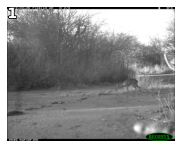

In [ ]:
dls2.show_batch()

In [ ]:
bb_list2, bb_score_list2, pred_list2  = get_bboxes(retModel.model, dls2.train, dls.c-1, detect_thresh=0.35)

In [ ]:
bb_list2

[TensorImage([[  11, 1065,  193,  359],
         [  10, 1573,  190,  346],
         [  10, 1319,  190,  355],
         [  10, 1191,  190,  355],
         [  12,  940,  194,  364],
         [   8,  297,  185,  358],
         [   0, 1504,  251,  257],
         [   0, 1666,  328,  175],
         [   9,  425,  189,  358],
         [   8,  169,  185,  358],
         [  10,  552,  190,  357],
         [  39, 1642,  114,  220],
         [   0, 1475,  344,  176],
         [   0, 1726,  338,  168],
         [  12,  812,  194,  365],
         [   0, 1642,   99,  220],
         [   0, 1410,  348,  175],
         [   0, 1347,  348,  176],
         [   0, 1489,  119,  288],
         [   0, 1155,  343,  176],
         [   0, 1282,  348,  175],
         [   0, 1218,  346,  175],
         [   0, 1604,  334,  179],
         [  38, 1449,  112,  219],
         [   0, 1231,  122,  286],
         [   0, 1359,  119,  285],
         [  35,    0,  262,  256],
         [   0, 1090,  346,  175],
         [  23,

In [ ]:
bb_score_list2

[TensorImage([0.7593, 0.7569, 0.7371, 0.7361, 0.7034, 0.6642, 0.6550, 0.6279, 0.6247,
         0.6221, 0.5769, 0.5708, 0.5671, 0.5654, 0.5646, 0.5593, 0.5574, 0.5561,
         0.5546, 0.5543, 0.5511, 0.5511, 0.5461, 0.5422, 0.5392, 0.5383, 0.5376,
         0.5308, 0.5303, 0.5259, 0.5208, 0.5029, 0.4976, 0.4962, 0.4936, 0.4847,
         0.4843, 0.4834, 0.4757, 0.4692, 0.4689, 0.4680, 0.4590, 0.4588, 0.4570,
         0.4508, 0.4498, 0.4477, 0.4437, 0.4417, 0.4416, 0.4361, 0.4293, 0.4280,
         0.4257, 0.4195, 0.4158, 0.4157, 0.4111, 0.4109, 0.4094, 0.4062, 0.4041,
         0.4008, 0.3998, 0.3995, 0.3985, 0.3961, 0.3943, 0.3938, 0.3923, 0.3920,
         0.3906, 0.3902, 0.3865, 0.3856, 0.3833, 0.3830, 0.3804, 0.3788, 0.3786,
         0.3783, 0.3776, 0.3758, 0.3740, 0.3736, 0.3733, 0.3726, 0.3719, 0.3705,
         0.3687, 0.3686, 0.3677, 0.3659, 0.3657, 0.3642, 0.3631, 0.3626, 0.3626,
         0.3601, 0.3590, 0.3589, 0.3581, 0.3556, 0.3529, 0.3514, 0.3513, 0.3501]),
 []]

In [ ]:
pred_list2

[TensorImage([45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45,
         45, 45, 45, 45, 45, 45, 45, 45, 23, 45, 23, 45, 45, 45, 45, 45, 45, 45,
         65, 45, 45, 45, 45, 45, 45, 23, 45, 45, 45, 45, 45, 23, 45, 45, 45, 45,
         45, 45, 45, 45, 45, 45, 23, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45,
         45, 45, 45, 45, 45, 45, 45, 45, 73, 45, 45, 45, 45, 45, 45, 45, 45, 45,
         45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 23, 45, 45, 45, 45, 45, 45, 45]),
 []]

# Quelle
https://github.com/muellerzr/Practical-Deep-Learning-for-Coders-2.0/blob/master/Computer%20Vision/06_Object_Detection.ipynb